https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V4: find correspondence (use individual image)

# Attention Map

In [2]:
!hostname

gl1514.arc-ts.umich.edu


In [3]:
# CONFIG
# model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
model_name = "facebook/sam2.1-hiera-small"
data_dir = "/home/minsukc/SIO/data/"
target_image_1 = "ct_chest_2.png"
target_image_2 = "ct_chest_2_translated_100_100.png"
# target_image_2 = "ct_chest_1.jpeg"
# target_image_2 = "ct_chest_2_translated_300_300.png"

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Sam2Processor, Sam2Model

# from transformers import AutoProcessor, Sam2VisionModel
from transformers.image_utils import load_image
import os

In [5]:
# Load model & image
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using device: {device}")

processor = Sam2Processor.from_pretrained(model_name)
sam2 = Sam2Model.from_pretrained(model_name)
model = sam2.vision_encoder
model = model.to(device)

image1 = load_image(os.path.join(data_dir, target_image_1))
image2 = load_image(os.path.join(data_dir, target_image_2))

# Match image sizes before concatenation
w1, h1 = image1.size
w2, h2 = image2.size
target_h = min(h1, h2)
target_w = min(w1, w2)

image1 = image1.resize((target_w, target_h))
image2 = image2.resize((target_w, target_h))

# 🔹 Choose concatenation direction:
# concat_direction = "horizontal"  # or "vertical"

# if concat_direction == "horizontal":
#     concat_image = Image.new("RGB", (target_w * 2, target_h))
#     concat_image.paste(image1, (0, 0))
#     concat_image.paste(image2, (target_w, 0))
# elif concat_direction == "vertical":
#     concat_image = Image.new("RGB", (target_w, target_h * 2))
#     concat_image.paste(image1, (0, 0))
#     concat_image.paste(image2, (0, target_h))
# else:
#     raise ValueError("concat_direction must be 'horizontal' or 'vertical'")

# image = concat_image

Using device: cuda


You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


In [6]:
def extract_patch_features(img, processor, model, device):
    inputs = processor(
        images=img,
        do_resize=False,
        do_center_crop=False,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)

    for i, h in enumerate(out.hidden_states):
        print(f"Layer {i}: {tuple(h.shape)}")

    featmap = out.hidden_states[-3][0]  # same layer you currently use
    Hf, Wf, C = featmap.shape
    patches = featmap.reshape(Hf * Wf, C)

    print(f"Feature map: {Hf}x{Wf}, dim={C}")
    print("------------")

    return patches, Hf, Wf

# Patch Similarity Map

In [7]:
fA, HA, WA = extract_patch_features(image1, processor, model, device)
fB, HB, WB = extract_patch_features(image2, processor, model, device)

print("A:", fA.shape)
print("B:", fB.shape)
print("A grid:", HA, WA)
print("B grid:", HB, WB)

Layer 0: (1, 256, 256, 96)
Layer 1: (1, 256, 256, 96)
Layer 2: (1, 128, 128, 192)
Layer 3: (1, 128, 128, 192)
Layer 4: (1, 64, 64, 384)
Layer 5: (1, 64, 64, 384)
Layer 6: (1, 64, 64, 384)
Layer 7: (1, 64, 64, 384)
Layer 8: (1, 64, 64, 384)
Layer 9: (1, 64, 64, 384)
Layer 10: (1, 64, 64, 384)
Layer 11: (1, 64, 64, 384)
Layer 12: (1, 64, 64, 384)
Layer 13: (1, 64, 64, 384)
Layer 14: (1, 64, 64, 384)
Layer 15: (1, 32, 32, 768)
Layer 16: (1, 32, 32, 768)
Feature map: 64x64, dim=384
------------
Layer 0: (1, 256, 256, 96)
Layer 1: (1, 256, 256, 96)
Layer 2: (1, 128, 128, 192)
Layer 3: (1, 128, 128, 192)
Layer 4: (1, 64, 64, 384)
Layer 5: (1, 64, 64, 384)
Layer 6: (1, 64, 64, 384)
Layer 7: (1, 64, 64, 384)
Layer 8: (1, 64, 64, 384)
Layer 9: (1, 64, 64, 384)
Layer 10: (1, 64, 64, 384)
Layer 11: (1, 64, 64, 384)
Layer 12: (1, 64, 64, 384)
Layer 13: (1, 64, 64, 384)
Layer 14: (1, 64, 64, 384)
Layer 15: (1, 32, 32, 768)
Layer 16: (1, 32, 32, 768)
Feature map: 64x64, dim=384
------------
A: torch

In [8]:
# # --- Create a grid of query patch indices (works for non-square grids) ---
# grid_size = 4  # 4x4 = 16 query points
# coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
# coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
# query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

# n_queries = len(query_indices)
# cols, rows = grid_size, grid_size
# print(f"Query grid: {rows}x{cols}, total {n_queries} queries")

In [9]:
# # --- Patch grid from feature map (robust for non-square inputs) ---
# patch_h, patch_w = Hf, Wf  # from feats.shape earlier
# num_patches = patch_feats.shape[0]
# assert num_patches == patch_h * patch_w, (
#     f"Expected {patch_h * patch_w}, got {num_patches}"
# )

# # --- Create evenly spaced query patches ---
# grid_size = 4
# coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
# coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
# query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

# cols = grid_size
# rows = grid_size
# print(f"Patch grid: {patch_h}x{patch_w}, queries: {len(query_indices)}")

# # ---- Figure setup ----
# fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# # ---- Left column: original image ----
# for r in range(rows):
#     ax_img = axes[r, 0]
#     ax_img.imshow(image)
#     ax_img.axis("off")

#     # mark query patch centers
#     for q_idx in query_indices:
#         qy, qx = divmod(q_idx, patch_w)
#         img_w, img_h = image.size
#         center_x = (qx + 0.5) * (img_w / patch_w)
#         center_y = (qy + 0.5) * (img_h / patch_h)
#         ax_img.scatter(
#             center_x,
#             center_y,
#             color="red",
#             s=30,
#             marker="o",
#             edgecolors="black",
#             linewidth=0.5,
#             alpha=0.8,
#         )

# # ---- Right grid: similarity maps ----
# ax_list = [
#     axes[r, c] if rows > 1 else axes[c] for r in range(rows) for c in range(1, cols + 1)
# ]

# for ax, q_idx in zip(ax_list, query_indices):
#     query_feat = patch_feats[q_idx : q_idx + 1]
#     sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
#     sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()
#     sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)

#     qy, qx = divmod(q_idx, patch_w)
#     ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
#     ax.scatter(qx, qy, color="red", s=40, marker="o", edgecolors="black", linewidth=0.5)
#     ax.set_title(f"({qx}, {qy})", fontsize=10)
#     ax.axis("off")

# print(f"Similarity map shape: {sim_map.shape}")
# plt.suptitle("SAM2 Patch Similarity", fontsize=16)
# plt.tight_layout()
# plt.show()


# PCA

In [ ]:
from sklearn.decomposition import PCA

# Convert tensors → numpy
fA_np = fA.cpu().numpy()  # [N_A, C]
fB_np = fB.cpu().numpy()  # [N_B, C]

# Fit PCA on BOTH images' features combined
all_feats = np.concatenate([fA_np, fB_np], axis=0)

# Use shared basis
# pca = PCA(n_components=3)
# pca.fit(all_feats)  # IMPORTANT: fit on both images
# pca_A = pca.transform(fA_np)  # [N_A, 3]
# pca_B = pca.transform(fB_np)  # [N_B, 3]

# Compute PCA individually
pca_A = PCA(n_components=3)
pca_A.fit(fA_np)  # fit only on image A
pca_A = pca_A.transform(fA_np)  # [N_A, 3]

pca_B = PCA(n_components=3)
pca_B.fit(fB_np)  # fit only on image B
pca_B = pca_B.transform(fB_np)  # [N_B, 3]


combined = np.concatenate([pca_A, pca_B], axis=0)
pmin = combined.min(axis=0, keepdims=True)
pmax = combined.max(axis=0, keepdims=True)

pca_A_norm = (pca_A - pmin) / (pmax - pmin + 1e-8)
pca_B_norm = (pca_B - pmin) / (pmax - pmin + 1e-8)

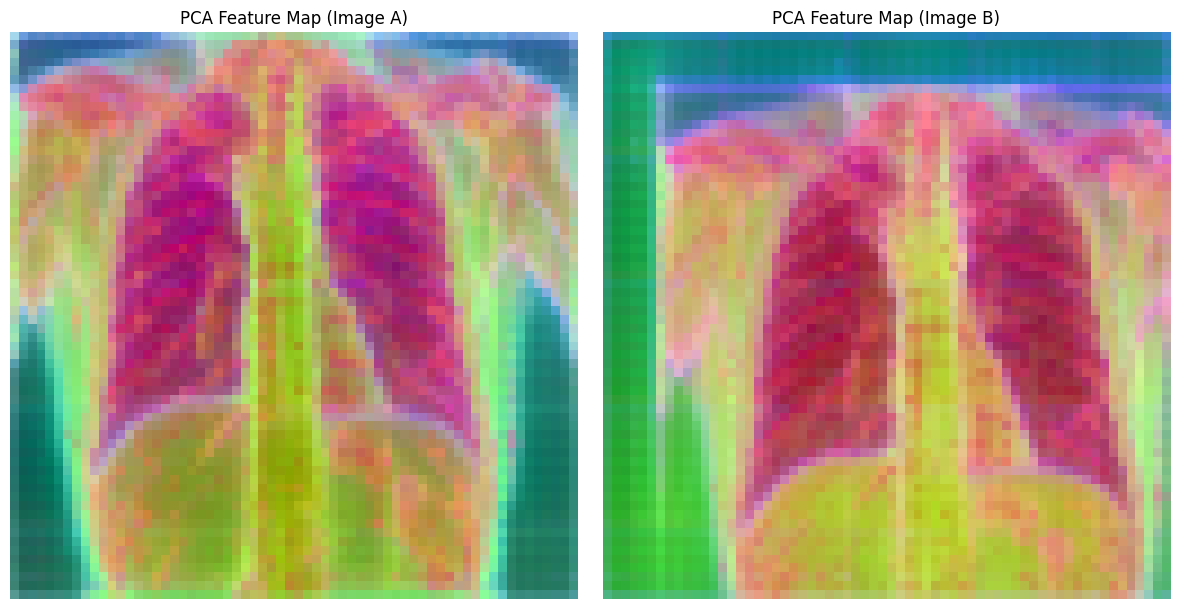

In [14]:
pca_A_img = pca_A_norm.reshape(HA, WA, 3)
pca_B_img = pca_B_norm.reshape(HB, WB, 3)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(pca_A_img)
axes[0].set_title("PCA Feature Map (Image A)")
axes[0].axis("off")

axes[1].imshow(pca_B_img)
axes[1].set_title("PCA Feature Map (Image B)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Correspondence

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_correspondences(
    imgA,
    imgB,
    HA,
    WA,
    HB,
    WB,
    match_B,
    num_samples=None,  # None = draw all
    sampling="grid",  # "grid" or "random"
):
    imgA = np.array(imgA)
    imgB = np.array(imgB)

    # match_B length = number of A patches
    N_A = len(match_B)

    # ---------------------------
    # 1) Determine patch indices to draw
    # ---------------------------
    if num_samples is None or num_samples >= N_A:
        indices = np.arange(N_A)
    else:
        if sampling == "grid":
            # pick evenly spaced indices
            indices = np.linspace(0, N_A - 1, num_samples, dtype=int)
        elif sampling == "random":
            indices = np.random.choice(N_A, num_samples, replace=False)
        else:
            raise ValueError("sampling must be 'grid' or 'random'")

    # ---------------------------
    # 2) Resize images to same height
    # ---------------------------
    h = max(imgA.shape[0], imgB.shape[0])
    imgA2 = cv2.resize(imgA, (imgA.shape[1], h))
    imgB2 = cv2.resize(imgB, (imgB.shape[1], h))

    # side-by-side canvas
    canvas = np.concatenate([imgA2, imgB2], axis=1)

    # ---------------------------
    # 3) Patch grid scaling
    # ---------------------------
    stepA_x = imgA2.shape[1] / WA
    stepA_y = h / HA
    stepB_x = imgB2.shape[1] / WB
    stepB_y = h / HB

    # ---------------------------
    # 4) Draw sampled correspondences
    # ---------------------------
    for i in indices:
        b_idx = match_B[i]

        # A patch center
        Ay = (i // WA) * stepA_y + stepA_y / 2
        Ax = (i % WA) * stepA_x + stepA_x / 2

        # B patch center
        By = (b_idx // WB) * stepB_y + stepB_y / 2
        Bx = (b_idx % WB) * stepB_x + stepB_x / 2 + imgA2.shape[1]

        pA = (int(Ax), int(Ay))
        pB = (int(Bx), int(By))

        # draw dots
        cv2.circle(canvas, pA, 5, (255, 0, 0), -1)  # blue dot on A
        cv2.circle(canvas, pB, 5, (0, 0, 255), -1)  # red dot on B

        # connect them
        cv2.line(canvas, pA, pB, (0, 255, 0), 2)

    # ---------------------------
    # 5) Display
    # ---------------------------
    plt.figure(figsize=(14, 6))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title("Patch Correspondence Lines")
    plt.show()


In [16]:
# Normalize features
fA = torch.nn.functional.normalize(fA, dim=-1)
fB = torch.nn.functional.normalize(fB, dim=-1)

sim = fA @ fB.T
print("sim:", sim.shape)


sim: torch.Size([4096, 4096])


In [17]:
def compute_correspondence(sim, WA, HA, WB, HB, r=None):
    """
    sim: [N_A, N_B] similarity matrix
    r: search radius (None = global search)
    """
    N_A = sim.shape[0]

    # Flattened B-grid coordinates (yB, xB)
    coords_y_B = np.arange(HB).repeat(WB)
    coords_x_B = np.tile(np.arange(WB), HB)

    match_B = []

    for i in range(N_A):
        # coords of patch i in A
        yA = i // WA
        xA = i % WA

        if r is None:  # -----------------------------------
            # GLOBAL SEARCH (no limits)
            # -----------------------------------------------
            best_j = sim[i].argmax().item()
            match_B.append(best_j)
            continue

        # -----------------------------------------------
        # LOCAL SEARCH within radius r
        # -----------------------------------------------
        y_min = max(0, yA - r)
        y_max = min(HB - 1, yA + r)
        x_min = max(0, xA - r)
        x_max = min(WB - 1, xA + r)

        # mask valid B patches
        mask = (
            (coords_y_B >= y_min)
            & (coords_y_B <= y_max)
            & (coords_x_B >= x_min)
            & (coords_x_B <= x_max)
        )

        valid_scores = sim[i][mask]
        valid_indices = np.where(mask)[0]

        best_j = valid_indices[valid_scores.argmax().item()]
        match_B.append(best_j)

    return np.array(match_B)


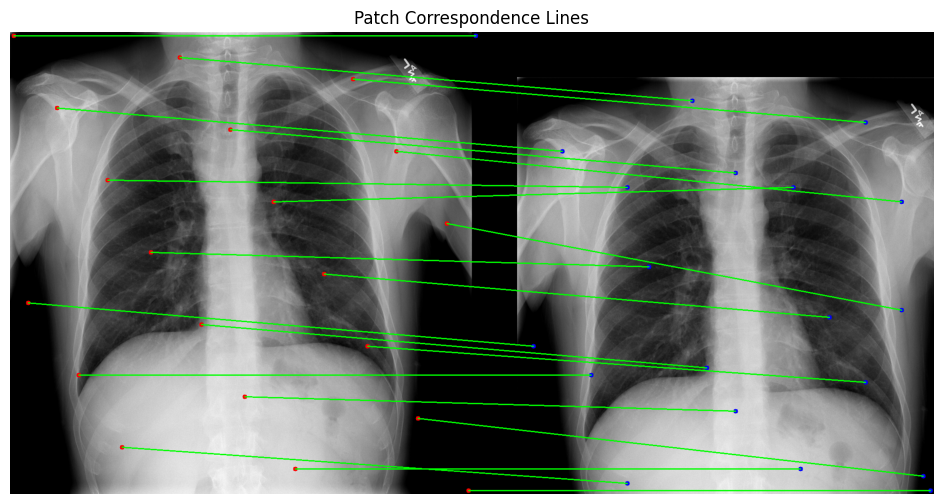

In [21]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=None)
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="grid"
)


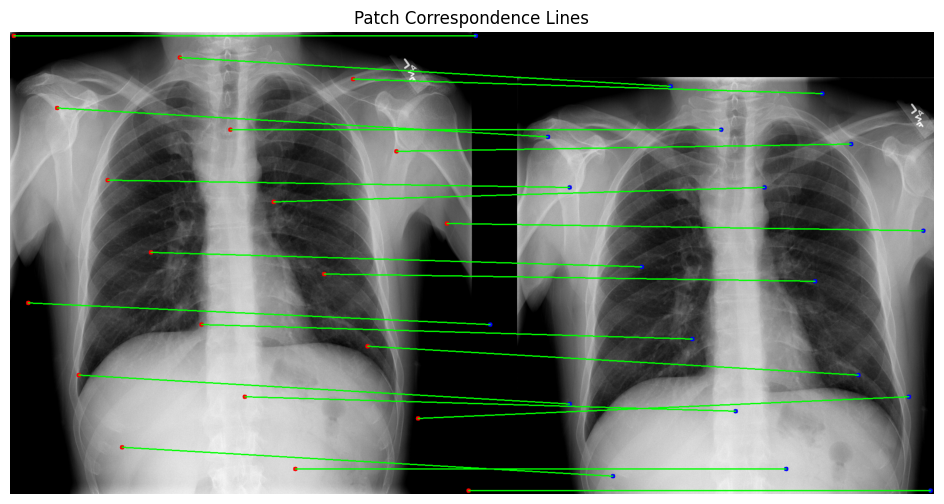

In [19]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=4)
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="grid"
)

In [ ]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=10)
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="grid"
)

In [2]:
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="random"
)

NameError: name 'draw_correspondences' is not defined